<a href="https://colab.research.google.com/github/ademaldemir/deeplearning/blob/master/chapter_3_regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 3.6. Predicting house prices: a regression example

In [2]:
from keras.datasets import boston_housing
import numpy as np


In [3]:
(train_data, train_targets), (test_data, test_targets) = boston_housing.load_data()

57344/57026 [==============================] - 0s 0us/step


In [4]:
train_data.shape

(404, 13)

In [5]:
test_data.shape

(102, 13)

In [6]:
train_data[0]

array([  1.23247,   0.     ,   8.14   ,   0.     ,   0.538  ,   6.142  ,
        91.7    ,   3.9769 ,   4.     , 307.     ,  21.     , 396.9    ,
        18.72   ])

In [7]:
train_targets[0]

15.2

In [8]:
np.max(train_data)

711.0

In [9]:
np.max(test_data)

711.0

## Normalizing the data

It would be problematic to feed into a neural network values that all take wildly different ranges. The network might be able to automatically adapt to such heterogeneous data, but it would definitely make learning more difficult. A widespread best practice to deal with such data is to do feature-wise normalization: for each feature in the input data (a column in the input data matrix), you subtract the mean of the feature and divide by the standard deviation, so that the feature is centered around 0 and has a unit standard deviation. This is easily done in Numpy.



In [10]:
mean = train_data.mean(axis=0)
mean[0]

3.7451105693069318

In [11]:
train_data -= mean

In [12]:
std = train_data.std(axis=0)
train_data /= std

In [13]:
test_data -= mean
test_data /= std

## BUILDING YOUR NETWORK

In [14]:
train_data.shape[1]

13

In [15]:
from keras.models import Sequential
from keras.layers import Dense

def build_model():
    model = Sequential()
    model.add(Dense(64, activation='relu', input_shape=(train_data.shape[1],)))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(1))
    model.compile(optimizer='rmsprop', loss='mse', metrics=['mae'])
    return model

## VALIDATING YOUR APPROACH USING K-FOLD VALIDATION

In [17]:
import numpy as np

k = 4
num_val_samples = len(train_data) // k
num_epochs = 100
all_scores = []
for i in range(k):
    print('processing fold #', i)
    val_data = train_data[i * num_val_samples: (i + 1) * num_val_samples]    
    val_targets = train_targets[i * num_val_samples: (i + 1) * num_val_samples]

    partial_train_data = np.concatenate(                                     
        [train_data[:i * num_val_samples],
         train_data[(i + 1) * num_val_samples:]],
        axis=0)
    partial_train_targets = np.concatenate(
        [train_targets[:i * num_val_samples],
         train_targets[(i + 1) * num_val_samples:]],
        axis=0)

    model = build_model()                                                    
    model.fit(partial_train_data, partial_train_targets,                     
              epochs=num_epochs, batch_size=1, verbose=0)
    val_mse, val_mae = model.evaluate(val_data, val_targets, verbose=0)      
    all_scores.append(val_mae)

processing fold # 0
processing fold # 1
processing fold # 2
processing fold # 3


In [ ]:
all_scores

[1.940312147140503, 3.009253978729248, 2.555952310562134, 2.339728593826294]

In [ ]:
np.mean(all_scores)

2.4613117575645447

In [21]:
num_epochs = 500
all_mae_histories = []
for i in range(k):
    print('processing fold #', i)
    val_data = train_data[i * num_val_samples: (i + 1) * num_val_samples]    
    val_targets = train_targets[i * num_val_samples: (i + 1) * num_val_samples]
    partial_train_data = np.concatenate(                                     
        [train_data[:i * num_val_samples],
         train_data[(i + 1) * num_val_samples:]],
        axis=0)
    partial_train_targets = np.concatenate(
        [train_targets[:i * num_val_samples],
         train_targets[(i + 1) * num_val_samples:]],
        axis=0)

    model = build_model()                                                    
    history = model.fit(partial_train_data, partial_train_targets,           
                        validation_data=(val_data, val_targets),
                        epochs=num_epochs, batch_size=1, verbose=1)
    mae_history = history.history['val_mae']
    all_mae_histories.append(mae_history)

processing fold # 0
Epoch 1/500
303/303 [==============================] - 0s 1ms/step - loss: 211.9861 - mae: 11.0441 - val_loss: 41.2114 - val_mae: 3.9471
Epoch 2/500
303/303 [==============================] - 0s 1ms/step - loss: 33.2180 - mae: 3.7827 - val_loss: 29.2155 - val_mae: 3.3515
Epoch 3/500
303/303 [==============================] - 0s 1ms/step - loss: 23.3078 - mae: 3.1555 - val_loss: 20.7992 - val_mae: 2.8922
Epoch 4/500
303/303 [==============================] - 0s 1ms/step - loss: 18.6543 - mae: 2.8209 - val_loss: 18.2394 - val_mae: 2.4567
Epoch 5/500
303/303 [==============================] - 0s 1ms/step - loss: 17.6592 - mae: 2.6880 - val_loss: 16.3207 - val_mae: 2.4264
Epoch 6/500
303/303 [==============================] - 0s 1ms/step - loss: 15.8381 - mae: 2.5922 - val_loss: 14.5610 - val_mae: 2.3227
Epoch 7/500
303/303 [==============================] - 0s 1ms/step - loss: 14.7358 - mae: 2.4696 - val_loss: 15.1806 - val_mae: 2.3988
Epoch 8/500
303/303 [============

In [22]:
average_mae_history = [np.mean([x[i] for x in all_mae_histories]) for i in range(num_epochs)]

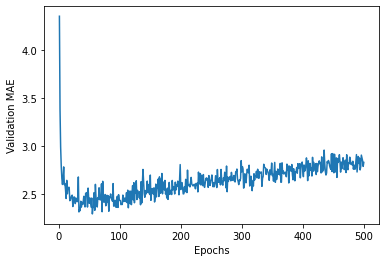

In [23]:
import matplotlib.pyplot as plt

plt.plot(range(1, len(average_mae_history) + 1), average_mae_history)
plt.xlabel('Epochs')
plt.ylabel('Validation MAE')
plt.show()

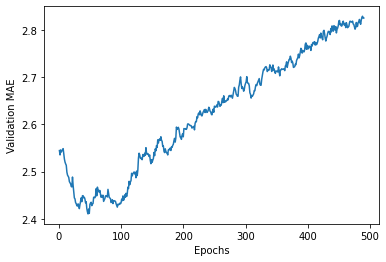

In [24]:
def smooth_curve(points, factor=0.9):
  smoothed_points = []
  for point in points:
    if smoothed_points:
      previous = smoothed_points[-1]
      smoothed_points.append(previous * factor + point * (1 - factor))
    else:
      smoothed_points.append(point)
  return smoothed_points

smooth_mae_history = smooth_curve(average_mae_history[10:])

plt.plot(range(1, len(smooth_mae_history) + 1), smooth_mae_history)
plt.xlabel('Epochs')
plt.ylabel('Validation MAE')
plt.show()

In [25]:
model = build_model()                                                     
model.fit(train_data, train_targets,                                      
          epochs=80, batch_size=16, verbose=0)
test_mse_score, test_mae_score = model.evaluate(test_data, test_targets)

4/4 [==============================] - 0s 2ms/step - loss: 18.4007 - mae: 2.8988


In [26]:
test_mae_score

2.898832321166992

# WRAPPING UP

Here’s what you should take away from this example:

* Regression is done using different loss functions than what we used for classification. Mean squared error (MSE) is a loss function commonly used for regression.
* Similarly, evaluation metrics to be used for regression differ from those used for classification; naturally, the concept of accuracy doesn’t apply for regression. A common regression metric is mean absolute error (MAE).
* When features in the input data have values in different ranges, each feature should be scaled independently as a preprocessing step.
* When there is little data available, using K-fold validation is a great way to reliably evaluate a model.
* When little training data is available, it’s preferable to use a small network with few hidden layers (typically only one or two), in order to avoid severe overfitting.